Welcome to the **[30 Days of ML competition](https://www.kaggle.com/c/30-days-of-ml/overview)**!  In this notebook, you'll learn how to make your first submission.

Before getting started, make your own editable copy of this notebook by clicking on the **Copy and Edit** button.

# Step 1: Import helpful libraries

We begin by importing the libraries we'll need.  Some of them will be familiar from the **[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)** course and the **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course.

In [154]:
# Familiar imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
from datetime import datetime

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p



# For ordinal encoding categorical variables, splitting data, pipeline, and so on
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.pipeline import make_pipeline

# For training random forest model
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# base
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


from sklearn.metrics import mean_squared_error


In [92]:
pd.set_option("display.max_columns", 100)

# Step 2: Load the data

Next, we'll load the training and test data.  

We set `index_col=0` in the code cell below to use the `id` column to index the DataFrame.  (*If you're not sure how this works, try temporarily removing `index_col=0` and see how it changes the result.*)

In [93]:
# Load the training data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

# Preview the data
train.head()
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cont0,300000.0,0.527335,0.230599,-0.118039,0.405965,0.497053,0.668060,1.058443
cont1,300000.0,0.460926,0.214003,-0.069309,0.310494,0.427903,0.615113,0.887253
cont2,300000.0,0.490498,0.253346,-0.056104,0.300604,0.502462,0.647512,1.034704
cont3,300000.0,0.496689,0.219199,0.130676,0.329783,0.465026,0.664451,1.039560
cont4,300000.0,0.491654,0.240074,0.255908,0.284188,0.390470,0.696599,1.055424
cont5,300000.0,0.510526,0.228232,0.045915,0.354141,0.488865,0.669625,1.067649
cont6,300000.0,0.467476,0.210331,-0.224689,0.342873,0.429383,0.573383,1.111552
cont7,300000.0,0.537119,0.218140,0.203763,0.355825,0.504661,0.703441,1.032837
cont8,300000.0,0.498456,0.239920,-0.260275,0.332486,0.439151,0.606056,1.040229
cont9,300000.0,0.474872,0.218007,0.117896,0.306874,0.434620,0.614333,0.982922


The next code cell separates the target (which we assign to `y`) from the training features (which we assign to `features`).

In [94]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# Preview features
features.head().T

id,1,2,3,4,6
cat0,B,B,A,B,A
cat1,B,B,A,B,A
cat2,B,A,A,A,A
cat3,C,A,C,C,C
cat4,B,B,B,B,B
cat5,B,D,D,D,D
cat6,A,A,A,A,A
cat7,E,F,D,E,E
cat8,C,A,A,C,A
cat9,N,O,F,K,N


# Step 3: Prepare the data

Next, we'll need to handle the categorical columns (`cat0`, `cat1`, ... `cat9`).  

In the **[Categorical Variables lesson](https://www.kaggle.com/alexisbcook/categorical-variables)** in the Intermediate Machine Learning course, you learned several different ways to encode categorical variables in a dataset.  In this notebook, we'll use ordinal encoding and save our encoded features as new variables `X` and `X_test`.

In [95]:
def add_poly_features(train, test, cols=None, concate=True, poly_degree=2):
    
    if cols is  None:
        cols = train.columns
     
    columns = train[cols].columns
    poly = PolynomialFeatures(poly_degree)
    poly_train = pd.DataFrame(poly.fit_transform(train[cols]), index=train.index)
    poly_test = pd.DataFrame(poly.transform(test[cols]), index=test.index)
    
    # stamp these columns
    poly_train = poly_train.add_prefix('poly_')
    poly_test = poly_test.add_prefix('poly_')
    
    if concate:
        train = pd.concat([train, poly_train], axis=1)
        test = pd.concat([test, poly_test], axis=1)
        
    return train, test



In [96]:

# List of categorical columns
object_cols_long = [col for col in features.columns if 'cat' in col]
cont_cols = [col for col in features.columns if 'con' in col]

X = features.copy()
X_test = test.copy()

# cols = ['cont0', 'cont3', 'cont9']
# add poly features
# X, X_test = add_poly_features(X, X_test, cols)


# encoding
ordinal_encoder = OrdinalEncoder()
X[object_cols_long] = ordinal_encoder.fit_transform(X[object_cols_long])
X_test[object_cols_long] = ordinal_encoder.transform(X_test[object_cols_long])

Next, we break off a validation set from the training data.

In [97]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [98]:
X_train.shape

(225000, 24)

# Step 4.1: Predict using Generalized Stacking


In [118]:

# helpers and wrappers
class ModelWrapper():
    def __init__(self, 
                 model,
                 uses_eval_set=False,
                 fit_params={}):
        
        self.model = model
        self.name = model.__class__.__name__
        
        self.uses_eval_set = uses_val_set # if the model uses eval-set for early stopping
        self.fit_params = fit_params # any extra params for the 'fit' function
        
#         self.valid_predictions = None # oof predictions on the valiation set
#         self.test_predictions = None  # meta-features on the test set
                
    def train(self, X, y):
        if self.use_eval_set:
            self.model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], **(self.fit_kwargs))
        else:
            self.model.fit(X_train, y_train, **(self.fit_kwargs)) 

    def predict(self, X):
        return self.model.predict(X)
        
    def clone(self):
        new_model = ModelWrapper(model=self.model,
                                 uses_eval_set=self.use_eval_set,
                                 fit_params=self.fit_params)
        new_model.name = self.name
        
        return new_model
        
class Experiment():
    def __init__(self,
                 title='Experiment'
                 n_folds=5,
                 random_state=42):
        
        self.title = title
        self.n_folds = n_folds
        self.random_state = random_state
        self.time_stamp=datetime.now().isoformat(' ', 'seconds')
    
    def get_experiment(self):
        return dict({"title": self.title,
                    "n_folds": self.n_fold,
                    "random_state": self.random_state,
                    "time_stamp": self.time_stamp})
        
    def __str__(self):
        return str(self.get_experiment())
    
        
class LevelTrainer():
    def __init__(self,
                 level_num=1,
                 
                )

def get_oof_predictions(model, X, y, X_test,
                        n_folds=5, 
                        shuffle=True, 
                        random_state=42
                        use_eval_set=False, 
                        **fit_kwargs):
    
    """ out of folds OOFs calculations
    """
    
    kfolds = KFold(n_splits=k, 
                  shuffle=shuffle,
                  random_state=random_state)
    
    test_predictions = 0
    t_valid_predictions = np.zeros_like(np.array(y))
    valid_mean_score = [] 
    
    for fold, (train_index, valid_index) in enumerate(kfolds.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        # create a clone
        model_ = clone(model)
                
        if use_eval_set:
            model_.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], **fit_kwargs)
        else:
            model_.fit(X_train, y_train, **fit_kwargs)
        
        # validation score
        valid_predications = model_.predict(X_valid)
        score = mean_squared_error(valid_predications, y_valid, squared=False)
        valid_mean_score.append(score)
        
        t_valid_predictions[valid_index] = valid_predications
        
        # test predictions
        test_predictions += model_.predict(X_test) / k
        
        print('Fold:{} score:{:.4f}'.format(fold + 1, score))
        
    print('average score:{:.4f} ({:.4f})'.format(np.mean(valid_mean_score), np.std(valid_mean_score) ))
    
    return t_valid_predictions, test_predictions


def store_oof_predictions(model_name,
               valid_predictions,
               test_predictions,
               X_train,
               X_test,
               stacking_level, 
               n_folds, 
               random_state):    
    
    """
    Store oof predictions into files.
    It is safe not to use defaults for this helper to make sure 
    we are storing the right experiement. 
    """
    assert model_name != ''
    
    if test_predictions is not None:
        test_df = pd.DataFrame({'Id': X_test.index,
                       model_name: test_predictions})
        test_df.to_csv( 'level_{}/{}_{}_test.csv'.format(stacking_level, model_name, n_folds),
                    index=False)
        
    if valid_predications is not None:
        valid_df = pd.DataFrame({'Id': X_train.index,
                           model_name: valid_predictions})
        valid_df.to_csv('level_{}/{}_{}_valid.csv'.format(stacking_level, model_name, n_folds), 
                    index=False)
    
    
def read_oof_predictions(pattern, 
                     models_names, 
                     index='id'):    
    """
    Read files according the pattern in their name
    it returns a dataframe where each column is the prediction of a model
    """
    li = [] 
    for f in glob.glob(pattern):
        file_name = f.split(os.sep)[1] # get file name only
        if file_name.lower().startswith(tuple(s.lower() for s in models_names)): # get only required models
            df = pd.read_csv(f, index_col=0)
            li.append(df)
    
                                   
    return pd.concat(li, axis=1)

    

### ML Models

#### Hyperparamater ranges
common ranges (to be added)

#### Hyperparameters: these should go to a JSON file

In [134]:
# extra-tree
et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

# random forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

# xgboost
# xgb_params = {'n_estimators': 10000,
#               'learning_rate': 0.35,
#               'subsample': 0.926,
#               'colsample_bytree': 0.84,
#               'max_depth': 2,
#               'booster': 'gbtree', 
#               'reg_lambda': 35.1,
#               'reg_alpha': 34.9,
#               'random_state': 42,
#               'n_jobs': -1}

# Using optuna but still rough
xgb_params = {'max_depth': 5,
             'learning_rate': 0.021252439960137114,
             'n_estimators': 13500,
             'subsample': 0.62,
             'booster': 'gbtree',
             'colsample_bytree': 0.1,
             'reg_lambda': 0.1584605320779582,
             'reg_alpha': 15.715145781076245,
             'n_jobs': -1}

# catboost
catb_params = {'iterations': 6800,
              'learning_rate': 0.93,
              'loss_function': "RMSE",
              'random_state': 42,
              'verbose': 0,
              'thread_count': 4,
              'depth': 1,
              'l2_leaf_reg': 3.28,
              'n_jobs': -1}

SEED = 7770777
params_lgb = {"n_estimators": 10000,   
            "boosting_type": "gbdt",
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.007899156646724397,
            "num_leaves": 77,
            "max_depth": 77,
            "feature_fraction": 0.2256038826485174,
            "bagging_fraction": 0.7705303688019942,
            "min_child_samples": 290,
            "reg_alpha": 9.562925363678952,
            "reg_lambda": 9.355810045480153,
            "max_bin": 772,
            "min_data_per_group": 177,
            "bagging_freq": 1,
            "cat_smooth": 96,
            "cat_l2": 17,
            "verbosity": -1,
            "bagging_seed": SEED,
            "feature_fraction_seed": SEED,
            "verbose_eval":1000,
            "seed": SEED,
            "n_jobs":-1}


In [126]:
# external hyperparamaters

### fit function hyperparamaters
# some models require special paramaters like early stoping in xgboost and lgbm

# xgboost
xgb_fit_params = {'early_stopping_rounds': 200,
                  'verbose': False}

# lgbm
lgb_fit_params = {'early_stopping_rounds': 200,
                  'verbose': False}

### application/implementation paramaters
# These paramaters are implementation dependent 

# xgboost
xgb_app_params = {'use_eval_set':True}

# lgbm
lgb_app_params = {'use_eval_set':True}

#### Models

In [127]:
# lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00005))

# Elastic net
e_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00005, l1_ratio=.9))

# KNeighborsRegressor
knn = make_pipeline(RobustScaler(), KNeighborsRegressor())

# extra-tree
extree = ExtraTreesRegressor(**et_params)

# random forest
rfr = RandomForestRegressor(**rf_params)

# xgboost
xgb =  XGBRegressor(**xgb_params)

#catboost
catb = CatBoostRegressor(**catb_params)

#lgbm
lgb = LGBMRegressor(**params_lgb)


In [152]:
# compile all settings in one dictionary, 
# we can store/load it then to a JSON file
models = {'Lasso': {"model":lasso, "fit_kwargs":None, "app_params": None},
          'ElasticNet': {"model": e_net, "fit_kwargs":None, "app_params": None},
          'ExtraTreesRegressor': {"model": extree, "fit_kwargs":None, "app_params": None},
          'RandomForestRegressor': {"model": rfr, "fit_kwargs":None, "app_params": None},
          'XGBRegressor': {"model": xgb, "fit_kwargs":xgb_fit_params, "app_params": xgb_fit_params},
          'CatBoostRegressor': {"model": catb, "fit_kwargs":None, "app_params": None},
          'LGBMRegressor': {"model": lgb, "fit_kwargs":lgb_fit_params, "app_params": lgb_app_params}
        }

### Stacking

Stacking with two levels:
we need two things:

oof predictions and test results.
- train level 1 models and collect their oof predictions 
- use oof predictions in another model and predict the final target.

- there are some variations to this simple procedure: see 
 - https://mlwave.com/kaggle-ensembling-guide/
 - https://www.kaggle.com/getting-started/18153#post103381
 
- one approach would be to:
    - train N models in the first level and get their oof predictions
    - train a model on the whole train set and get it's predictions
    

In [143]:
# ['RandomForestRegressor', 
# 'ExtraTreesRegressor',
# 'XGBRegressor',
# 'CatBoostRegressor'
# ]


experiment_settings = { 'level_1_models': ['all'],
                        'meta_model': 'XGBRegressor',
                        'n_folds_list': [5],
                        'random_states' : [42],
                        'verbose' : True      
                      }

# if level_1_models is set to 'all' use the models
if experiment_settings['level_1_models'][0].lower() == 'all':
    level_1_models_names = models.keys()
else: 
    level_1_models_names = experiment_settings['level_1_models']

In [146]:
# main procedure
for k, state in zip(experiment_settings['n_folds_list'], 
                          experiment_settings['random_states']):
    
    for model_name in level_1_models_names:
        
        # get paramaters for 
        model = models[model_name]
        fit_kwargs = models[model_name]['fit_kwargs']
        app_params = models[model_name]['app_params'] 
        
        print('-'*30)
        print (model_name)
        print('Calculating oof predictions')
        
        # get oof predictions 
        if fit_kwargs is not None:
            oof_validations, oof_tests = get_oof_predictions(model,X, y, X_test,
                                                             k, 
                                                             random_state=state,
                                                             use_eval_set=app_params['use_eval_set'],
                                                             fit_kwargs=fit_kwargs)
 
        print('Storing oof predictions')
        # store them
        store_oof_predictions(name, 
                              oof_validations, 
                              oof_tests, 
                              X, X_test, 
                              stacking_level=1, 
                              n_folds=k, random_state=state)
        print('-'*30)

------------------------------
Lasso
Calculating oof predictions


NameError: name 'use_eval_set' is not defined

In this approach I am going to run k-folds using each model and average the rest results among folds.


In [11]:
lasso_test_results, lasso_valid_results = calc_oof_predictions(lasso, X, y, X_test, model_name='lasso')

Fold:1 score:0.7434
Fold:2 score:0.7340
Fold:3 score:0.7360
Fold:4 score:0.7370
Fold:5 score:0.7451
Fold:6 score:0.7421
Fold:7 score:0.7342
Fold:8 score:0.7404
Fold:9 score:0.7352
Fold:10 score:0.7421
Fold:11 score:0.7447
Fold:12 score:0.7363
average score:0.7392 (0.0040)


In [12]:
enet_test_results, enet_valid_results = calc_oof_predictions(e_net, X, y, X_test, model_name='Enet')

Fold:1 score:0.7434
Fold:2 score:0.7340
Fold:3 score:0.7360
Fold:4 score:0.7370
Fold:5 score:0.7451
Fold:6 score:0.7421
Fold:7 score:0.7342
Fold:8 score:0.7405
Fold:9 score:0.7352
Fold:10 score:0.7421
Fold:11 score:0.7447
Fold:12 score:0.7363
average score:0.7392 (0.0040)


In [13]:
xgb_test_results, xgb_valid_results = calc_oof_predictions(xgb, X, y, X_test, use_eval_set=True,
                   early_stopping_rounds=200,
                   verbose=False)

Fold:1 score:0.7191
Fold:2 score:0.7138
Fold:3 score:0.7136
Fold:4 score:0.7155
Fold:5 score:0.7210
Fold:6 score:0.7201
Fold:7 score:0.7142
Fold:8 score:0.7187
Fold:9 score:0.7140
Fold:10 score:0.7200
Fold:11 score:0.7200
Fold:12 score:0.7120
average score:0.7168 (0.0031)


In [14]:
lgb_test_results, lgb_valid_results = calc_oof_predictions(lgb, X, y, X_test, use_eval_set=True,
                   early_stopping_rounds=200,
                   verbose=False)

Fold:1 score:0.7199
Fold:2 score:0.7138
Fold:3 score:0.7141
Fold:4 score:0.7164
Fold:5 score:0.7213
Fold:6 score:0.7203
Fold:7 score:0.7138
Fold:8 score:0.7192
Fold:9 score:0.7142
Fold:10 score:0.7205
Fold:11 score:0.7211
Fold:12 score:0.7131
average score:0.7173 (0.0032)


In [15]:
catb_test_results, catb_valid_results = calc_oof_predictions(catb, X, y, X_test)

Fold:1 score:0.7209
Fold:2 score:0.7145
Fold:3 score:0.7149
Fold:4 score:0.7175
Fold:5 score:0.7224
Fold:6 score:0.7209
Fold:7 score:0.7149
Fold:8 score:0.7203
Fold:9 score:0.7146
Fold:10 score:0.7215
Fold:11 score:0.7219
Fold:12 score:0.7138
average score:0.7182 (0.0033)


In [16]:
extree_test_results, extree_valid_results = calc_oof_predictions(extree, X, y, X_test)

Fold:1 score:0.7396
Fold:2 score:0.7313
Fold:3 score:0.7334
Fold:4 score:0.7348
Fold:5 score:0.7421
Fold:6 score:0.7399
Fold:7 score:0.7316
Fold:8 score:0.7382
Fold:9 score:0.7327
Fold:10 score:0.7397
Fold:11 score:0.7418
Fold:12 score:0.7336
average score:0.7366 (0.0039)


In [17]:
rfr_test_results, rfr_valid_results = calc_oof_predictions(rfr, X, y, X_test)

Fold:1 score:0.7401
Fold:2 score:0.7317
Fold:3 score:0.7336
Fold:4 score:0.7348
Fold:5 score:0.7420
Fold:6 score:0.7396
Fold:7 score:0.7318
Fold:8 score:0.7381
Fold:9 score:0.7328
Fold:10 score:0.7396
Fold:11 score:0.7416
Fold:12 score:0.7337
average score:0.7366 (0.0038)


In [85]:
                         
# required results                            
fold_id = 12
folder ='level_1'
                            
level_1_models = ['RandomForestRegressor', 
                  'ExtraTreesRegressor',
                  'XGBRegressor',
                  'CatBoostRegressor'
                  ]

meta_regressor = 'LGBMRegressor'



# new features 
X_train_ = read_results_set(pattern=f"{folder}{os.sep}*{fold_id}_valid.csv",
                           models_names=level_1_models)
X_test_ = read_results_set(pattern=f"{folder}{os.sep}*{fold_id}_test.csv",
                          models_names=level_1_models)

X_train_.head()

ElasticNet_12_valid.csv
Lasso_12_valid.csv
CatBoostRegressor_12_valid.csv
RandomForestRegressor_12_valid.csv
XGBRegressor_12_valid.csv
ExtraTreesRegressor_12_valid.csv
LGBMRegressor_12_valid.csv
4
ExtraTreesRegressor_12_test.csv
CatBoostRegressor_12_test.csv
LGBMRegressor_12_test.csv
ElasticNet_12_test.csv
XGBRegressor_12_test.csv
Lasso_12_test.csv
RandomForestRegressor_12_test.csv
4


,feature,feature,feature,feature
Id,,,,
1,8.457421,8.255680,8.419353,8.244644
2,8.361938,8.315244,8.432220,8.293434
3,8.222198,8.140362,8.180540,8.156236
4,8.392812,8.279955,8.401962,8.284501
6,8.278599,8.187986,8.133272,8.189441


In [86]:
X_train_.columns = [str(i) for i in range(len(X_train_.columns))]
X_test_.columns = [str(i) for i in range(len(X_train_.columns))]
#X_train_, X_test_ = add_poly_features(X_train_, X_test_, concate=True, poly_degree=2)
#X_train_.drop(['poly_0', 'poly_1' ,'poly_2','poly_3', 'poly_4'], inplace =True, axis=1)
#X_test_.drop(['poly_0', 'poly_1' ,'poly_2','poly_3', 'poly_4'], inplace =True, axis=1)
# X_train_['q_3'] = pd.qcut(X_train_['3'], 35)
# y_ = pd.cut(y, 5)
# oe = LabelEncoder()
# X_train_['q_3'] = oe.fit(y_).transform(X_train_['3'])
# X_test_['q_3'] = pd.cut(X_test_['3'], 5)
# X_test_['q_3'] = oe.transform(X_test_['q_3'])

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>],
       [<AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>]], dtype=object)

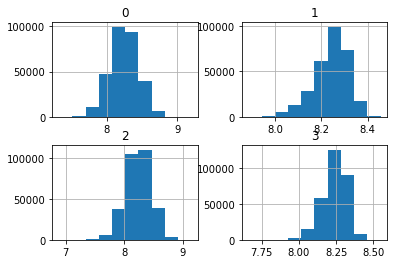

In [87]:
X_train_.hist()

In [ ]:
pd.cut(y, 5).value_counts()

In [ ]:
X_train_.head()

In [ ]:
X_train_.head()

In [117]:
meta_test_results, meta_valid_results = get_oof_predictions(xgb, X_train, y, X_test, k=5, model_name='Meta_1')

KeyboardInterrupt: 

In [114]:
meta_valid_results, meta_test_results = get_oof_predictions(lasso, X_train_, y, X_test_, k=5, model_name='Meta_1')

Fold:1 score:0.7161
Fold:2 score:0.7160
Fold:3 score:0.7180
Fold:4 score:0.7177
Fold:5 score:0.7158
average score:0.7167 (0.0010)


In [ ]:
#results = np.exp((np.log(lasso_test_results) + np.log(xgb_test_results) + np.log(lgb_test_results) + np.log(catb_test_results)) / 4 )
results = np.exp(np.sum(np.log(np.column_stack(test_stack)) / 4, axis=1))
#mean_squared_error(y, y3, squared=False)

In [110]:
predictions = meta_valid_results

<hr>

In the code cell above, we set `squared=False` to get the root mean squared error (RMSE) on the validation data.

# Step 5: Submit to the competition

We'll begin by using the trained model to generate predictions, which we'll save to a CSV file.

In [111]:
predictions.shape

(200000,)

In [112]:
# Save the predictions to a CSV file
output = pd.DataFrame({'Id': X_test.index,
                       'target': predictions})
output.to_csv('submission.csv', index=False)

In [113]:
output.head(10)

,Id,target
0,0,8.069916
1,5,8.343784
2,15,8.361576
3,16,8.417953
4,17,8.155354
5,19,8.284881
6,20,8.462473
7,21,7.935788
8,23,8.136220
9,29,8.309392


In [ ]:
output.head(10)